In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!pip install kaggle


In [5]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset -p /content


Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 97% 117M/121M [00:01<00:00, 140MB/s] 
100% 121M/121M [00:01<00:00, 115MB/s]


In [6]:
!unzip /content/face-expression-recognition-dataset.zip -d /content/face-expression-recognition-dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/8797.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/8818.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/886.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9037.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9040.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9101.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/911.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9179.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9205.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9232.jpg  
  inflating: /content/face-expr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
TRAIN_DIR = "/content/face-expression-recognition-dataset/images/train"
TEST_DIR = "/content/face-expression-recognition-dataset/images/test"

print("Train directory:", TRAIN_DIR)
print("Test directory:", TEST_DIR)


Train directory: /content/face-expression-recognition-dataset/images/train
Test directory: /content/face-expression-recognition-dataset/images/test


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
TRAIN_DIR = "/content/face-expression-recognition-dataset/images/images/train"
TEST_DIR = "/content/face-expression-recognition-dataset/images/images/validation"


In [10]:
# Normalize pixel values to [0, 1] and apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load train and test data
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48, 48),  # Resize to 48x48 pixels
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [11]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
def extract_features(images):
  features = []
  for image in tqdm(images):
    # Use color_mode='grayscale' instead of grayscale
    img = load_img(image, color_mode='grayscale')
    img = np.array(img)
    features.append(img)
    features = np.array(features)
  features = features.reshape(len(features),48,48,1)
  return features

In [12]:
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def extract_features(directory):
  """
  Extracts features from images in the specified directory.

  Args:
    directory: The directory containing the images.

  Returns:
    A NumPy array of image features.
  """
  features = []
  # Get list of all image files in the directory
  image_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(('.jpg', '.png', '.jpeg'))]

  for image_path in tqdm(image_paths):
    # Load image in grayscale and convert to NumPy array
    img = load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img = img_to_array(img)
    features.append(img)

  # Convert features list to NumPy array and reshape
  features = np.array(features)
  features = features.reshape(len(features), 48, 48, 1)
  return features

# Assuming TRAIN_DIR and TEST_DIR are defined
train_features = extract_features(TRAIN_DIR)
test_features = extract_features(TEST_DIR)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [13]:
x_train = train_features
y_train = train_data.classes
x_test = test_features
y_test = test_data.classes

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 196s 215ms/step - accuracy: 0.2316 - loss: 1.8421 - val_accuracy: 0.2624 - val_loss: 1.7801
Epoch 2/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 171s 181ms/step - accuracy: 0.2485 - loss: 1.7990 - val_accuracy: 0.2845 - val_loss: 1.7481
Epoch 3/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 200s 178ms/step - accuracy: 0.2616 - loss: 1.7818 - val_accuracy: 0.2999 - val_loss: 1.7159
Epoch 4/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 159s 176ms/step - accuracy: 0.2666 - loss: 1.7668 - val_accuracy: 0.3033 - val_loss: 1.7103
Epoch 5/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 162s 180ms/step - accuracy: 0.2808 - loss: 1.7464 - val_accuracy: 0.3197 - val_loss: 1.6646
Epoch 6/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 160s 177ms/step - accuracy: 0.2885 - loss: 1.7281 - val_accuracy: 0.3551 - val_loss: 1.6087
Epoch 7/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 165s 182ms/step - accuracy: 0.3083 - loss: 1.7020 - val_accuracy: 0.3862 - val_loss: 1.5784
Epoch 8/35
901/901 ━━━━━━━━━━━━━━━━━━━━ 164s 182ms/step - accuracy: 0.3263 - loss: 1.67

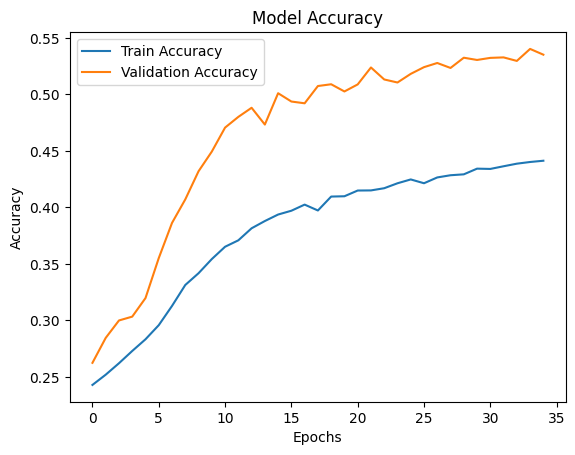

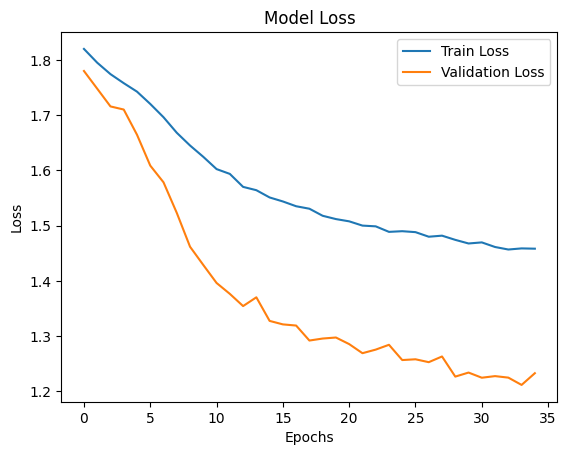

221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


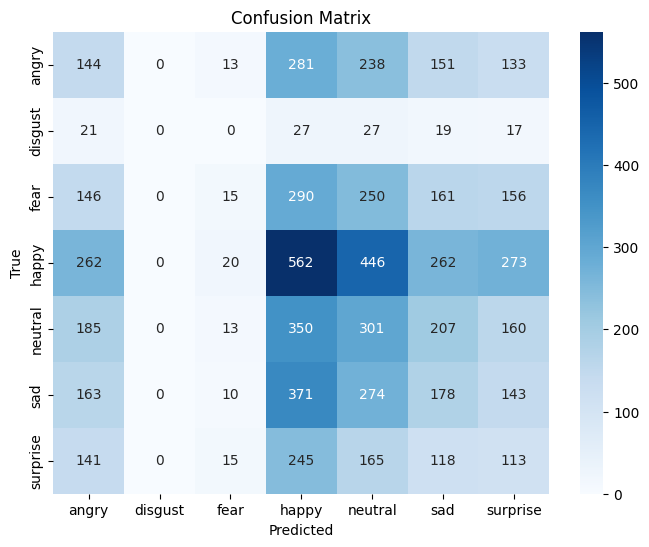

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       960
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.01      0.03      1018
       happy       0.26      0.31      0.28      1825
     neutral       0.18      0.25      0.21      1216
         sad       0.16      0.16      0.16      1139
    surprise       0.11      0.14      0.13       797

    accuracy                           0.19      7066
   macro avg       0.15      0.15      0.14      7066
weighted avg       0.18      0.19      0.17      7066



In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Set directories for the dataset
TRAIN_DIR = "/content/face-expression-recognition-dataset/images/images/train"
TEST_DIR = "/content/face-expression-recognition-dataset/images/images/validation"

# Normalize pixel values to [0, 1] and apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load train and test data
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(48, 48),  # Resize to 48x48 pixels
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(train_data.num_classes, activation='softmax')  # Output layer for classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=35,
    callbacks=[early_stopping]
)

# Evaluate on the test data
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Confusion Matrix and Classification Report for CNN model
test_labels = test_data.classes
predictions = model.predict(test_data, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=list(test_data.class_indices.keys())))

# Save CNN model to JSON and .h5
model_json = model.to_json()
with open("emotiondetector.json", 'w') as json_file:
    json_file.write(model_json)
model.save("emotiondetector.h5")

# ------------- Comparing with Machine Learning Models -------------
# Load images from directory (without augmentation)


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import cv2
x_train, x_test, y_train, y_test = [], [], [], []
for directory in os.listdir(TRAIN_DIR):
    for image_path in os.listdir(os.path.join(TRAIN_DIR, directory)):
        img = plt.imread(os.path.join(TRAIN_DIR, directory, image_path))
        img = cv2.resize(img, (48, 48))  # Resize the image to 48x48 pixels
        x_train.append(img)
        y_train.append(directory)

for directory in os.listdir(TEST_DIR):
    for image_path in os.listdir(os.path.join(TEST_DIR, directory)):
        img = plt.imread(os.path.join(TEST_DIR, directory, image_path))
        img = cv2.resize(img, (48, 48))  # Resize the image to 48x48 pixels
        x_test.append(img)
        y_test.append(directory)

x_train = np.array(x_train)
x_test = np.array(x_test)

# Flatten images for ML models
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Label encode the target labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Create and evaluate the machine learning models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model.fit(x_train_flat, y_train_enc)
    y_pred = model.predict(x_test_flat)
    print(f"Accuracy of {model_name}: {model.score(x_test_flat, y_test_enc):.4f}")
    print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))




Evaluating Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression: 0.3344
              precision    recall  f1-score   support

       angry       0.22      0.18      0.20       960
     disgust       0.24      0.12      0.16       111
        fear       0.24      0.19      0.21      1018
       happy       0.45      0.57      0.51      1825
     neutral       0.32      0.31      0.31      1216
         sad       0.23      0.22      0.22      1139
    surprise       0.37      0.41      0.39       797

    accuracy                           0.33      7066
   macro avg       0.30      0.28      0.28      7066
weighted avg       0.32      0.33      0.32      7066


Evaluating SVM...
Accuracy of SVM: 0.4563
              precision    recall  f1-score   support

       angry       0.40      0.21      0.27       960
     disgust       1.00      0.04      0.07       111
        fear       0.44      0.25      0.32      1018
       happy       0.50      0.74      0.60      1825
     neutral       0.42      0.42      0.42      

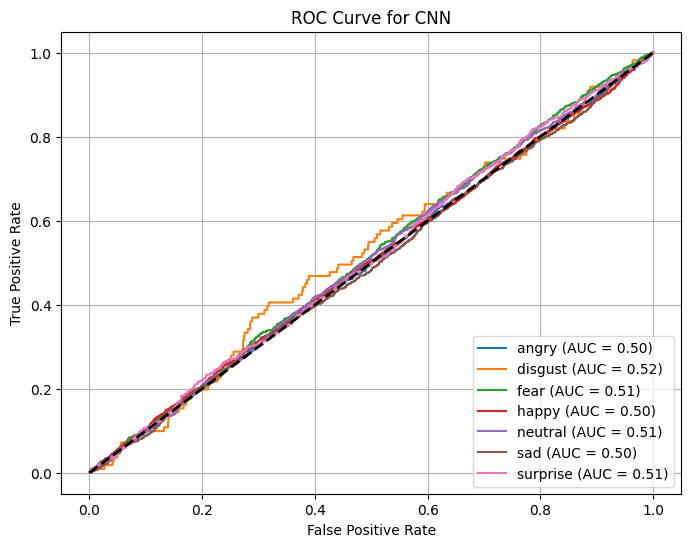

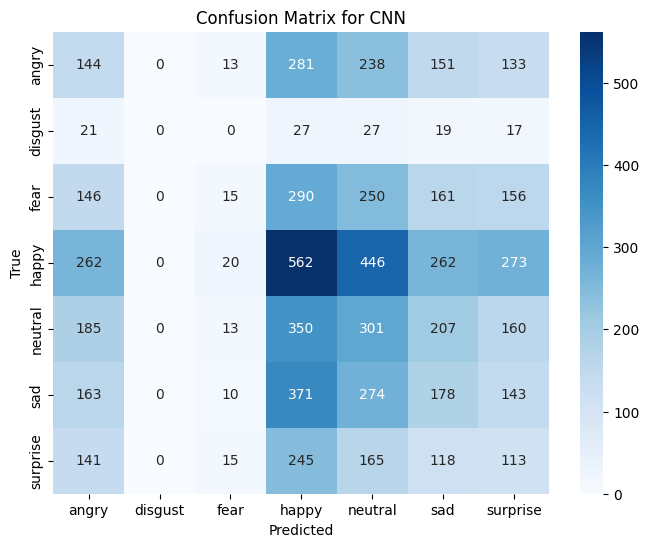


Evaluating Logistic Regression...


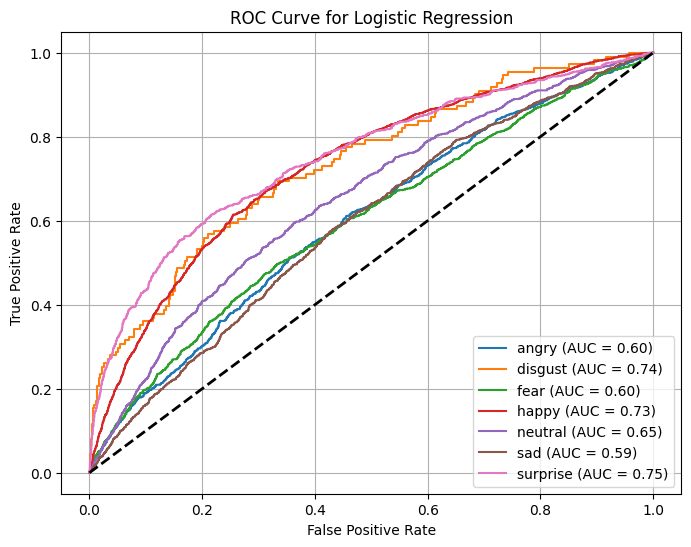

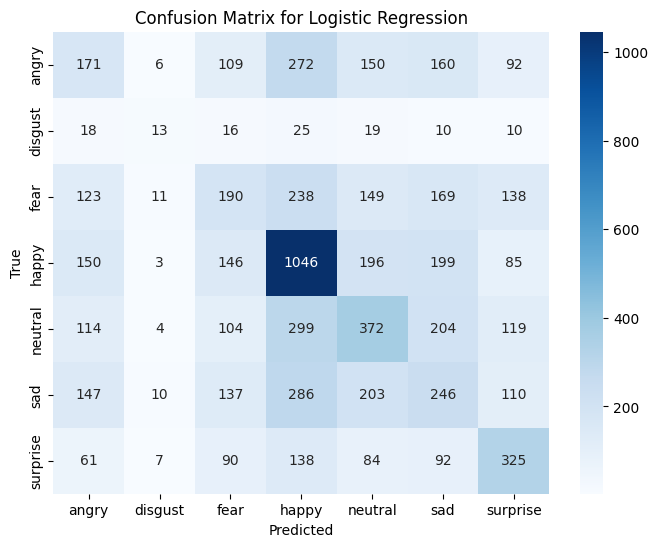

              precision    recall  f1-score   support

       angry       0.22      0.18      0.20       960
     disgust       0.24      0.12      0.16       111
        fear       0.24      0.19      0.21      1018
       happy       0.45      0.57      0.51      1825
     neutral       0.32      0.31      0.31      1216
         sad       0.23      0.22      0.22      1139
    surprise       0.37      0.41      0.39       797

    accuracy                           0.33      7066
   macro avg       0.30      0.28      0.28      7066
weighted avg       0.32      0.33      0.32      7066


Evaluating SVM...


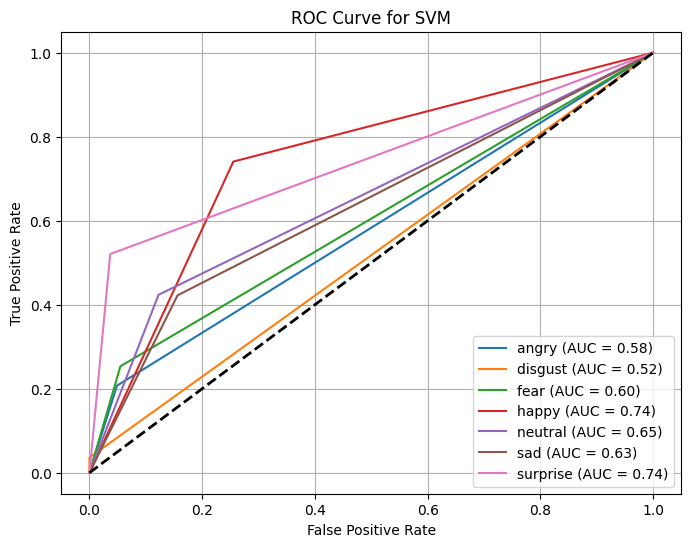

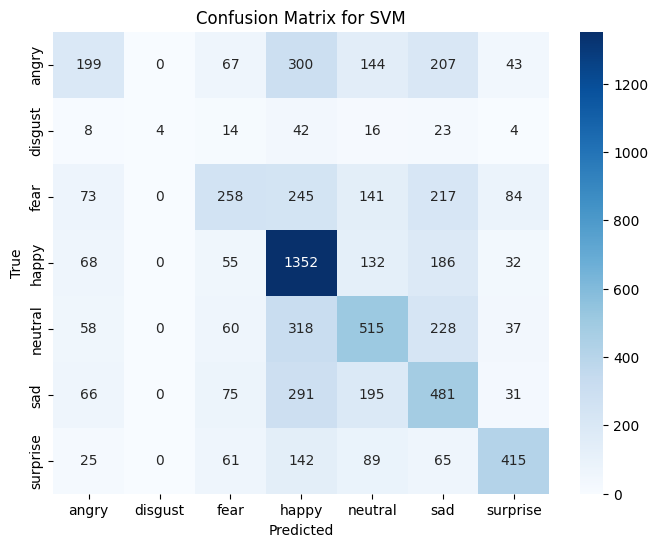

              precision    recall  f1-score   support

       angry       0.40      0.21      0.27       960
     disgust       1.00      0.04      0.07       111
        fear       0.44      0.25      0.32      1018
       happy       0.50      0.74      0.60      1825
     neutral       0.42      0.42      0.42      1216
         sad       0.34      0.42      0.38      1139
    surprise       0.64      0.52      0.58       797

    accuracy                           0.46      7066
   macro avg       0.53      0.37      0.38      7066
weighted avg       0.46      0.46      0.44      7066


Evaluating Random Forest...


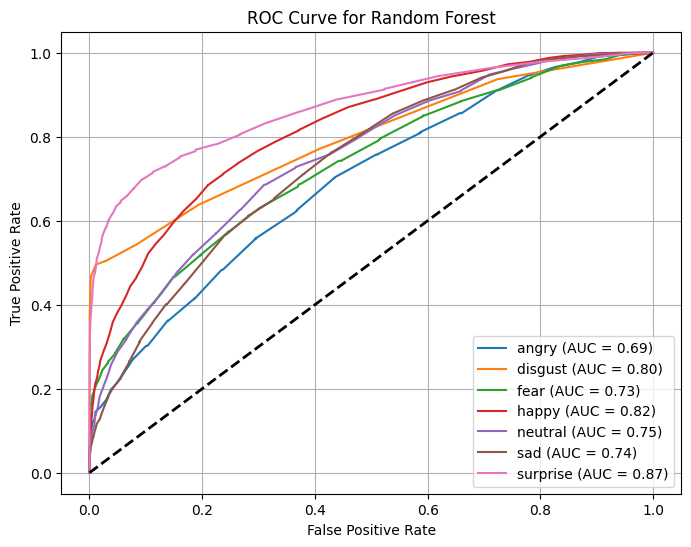

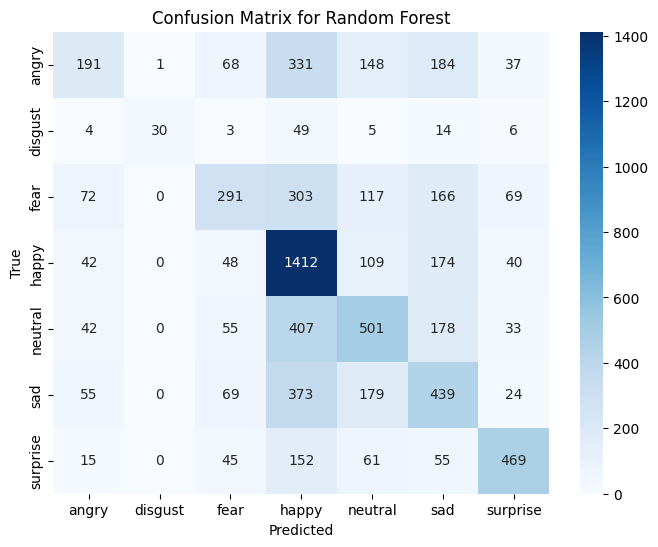

              precision    recall  f1-score   support

       angry       0.45      0.20      0.28       960
     disgust       0.97      0.27      0.42       111
        fear       0.50      0.29      0.36      1018
       happy       0.47      0.77      0.58      1825
     neutral       0.45      0.41      0.43      1216
         sad       0.36      0.39      0.37      1139
    surprise       0.69      0.59      0.64       797

    accuracy                           0.47      7066
   macro avg       0.56      0.42      0.44      7066
weighted avg       0.48      0.47      0.45      7066


Evaluating KNN...


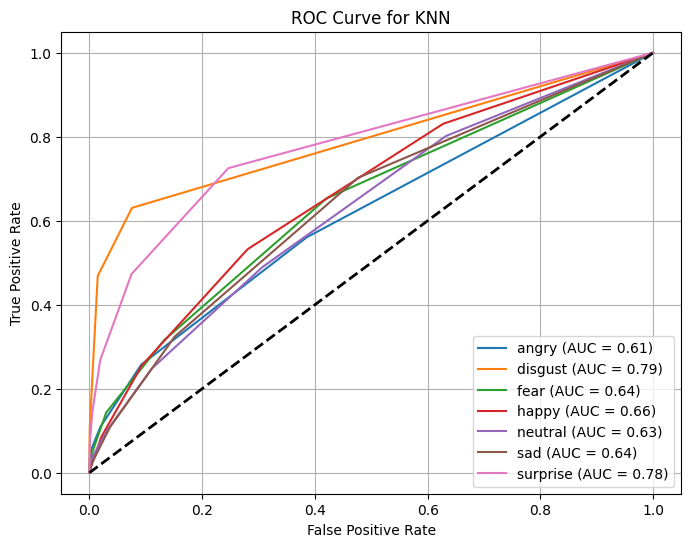

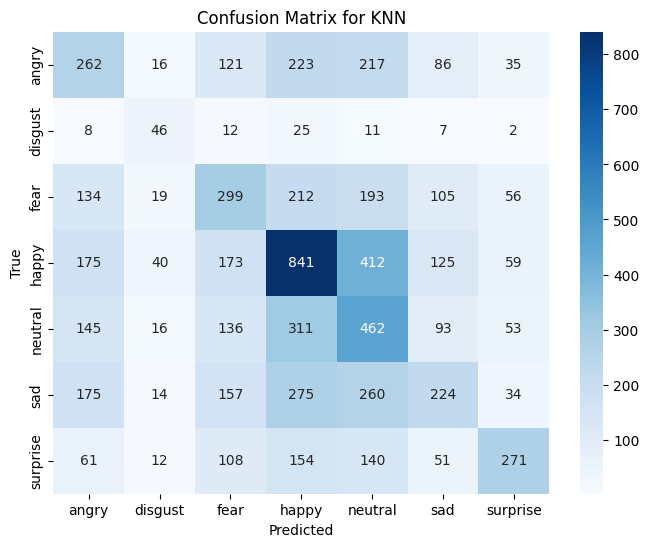

              precision    recall  f1-score   support

       angry       0.27      0.27      0.27       960
     disgust       0.28      0.41      0.34       111
        fear       0.30      0.29      0.30      1018
       happy       0.41      0.46      0.44      1825
     neutral       0.27      0.38      0.32      1216
         sad       0.32      0.20      0.24      1139
    surprise       0.53      0.34      0.41       797

    accuracy                           0.34      7066
   macro avg       0.34      0.34      0.33      7066
weighted avg       0.35      0.34      0.34      7066


Evaluating Decision Tree...


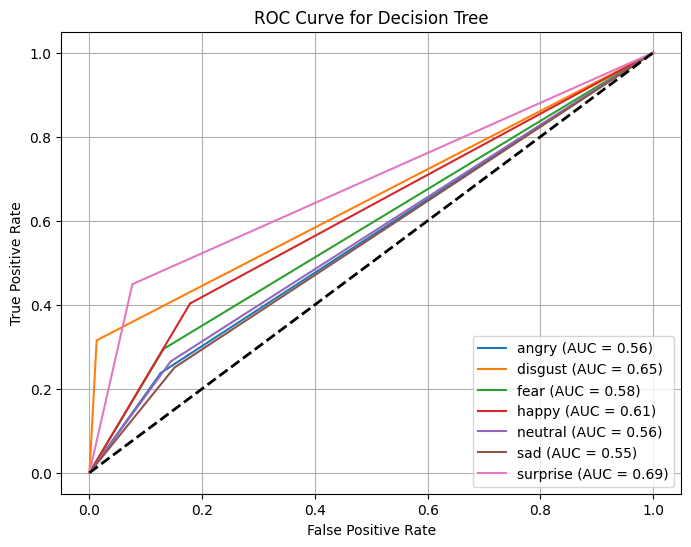

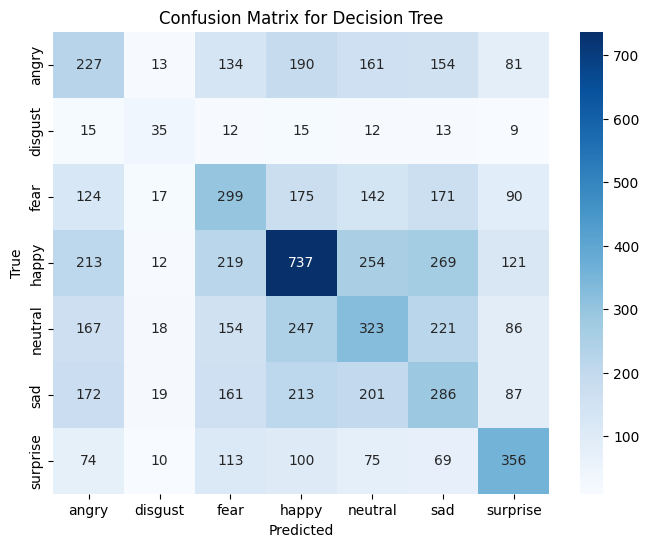

              precision    recall  f1-score   support

       angry       0.23      0.24      0.23       960
     disgust       0.28      0.32      0.30       111
        fear       0.27      0.29      0.28      1018
       happy       0.44      0.40      0.42      1825
     neutral       0.28      0.27      0.27      1216
         sad       0.24      0.25      0.25      1139
    surprise       0.43      0.45      0.44       797

    accuracy                           0.32      7066
   macro avg       0.31      0.32      0.31      7066
weighted avg       0.32      0.32      0.32      7066



In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Function to plot ROC Curve
def plot_roc_curve(y_test, y_pred_proba, model_name, classes):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot ROC Curve for CNN
y_test_bin = to_categorical(test_labels, num_classes=train_data.num_classes)
plot_roc_curve(test_labels, predictions, "CNN", list(test_data.class_indices.keys()))

# Confusion Matrix for CNN
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC and Confusion Matrix for Traditional ML Models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    # Get probabilities for ROC
    if hasattr(model, "predict_proba"):
        # Use x_test_flat instead of X_test_flat
        y_pred_proba = model.predict_proba(x_test_flat)
    else:
        # For SVM (no predict_proba), use decision_function instead
        y_pred_proba = np.zeros((len(y_test_enc), len(label_encoder.classes_)))
        # Use x_test_flat instead of X_test_flat
        y_pred_proba[np.arange(len(y_test_enc)), model.predict(x_test_flat)] = 1

    # Plot ROC Curve
    plot_roc_curve(y_test_enc, y_pred_proba, model_name, label_encoder.classes_)

    # Confusion Matrix
    # Use x_test_flat instead of X_test_flat
    y_pred = model.predict(x_test_flat)
    cm = confusion_matrix(y_test_enc, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))


In [25]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
sample_image_path = os.path.join(TRAIN_DIR, 'happy', 'some_image.jpg')  # Replace 'happy' with any class
print("Sample Image Path:", sample_image_path)


Sample Image Path: /content/face-expression-recognition-dataset/images/images/train/happy/some_image.jpg


In [27]:
!wget -O sample_image.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/440px-Golde33443.jpg

--2024-11-28 09:49:47--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/440px-Golde33443.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86142 (84K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>]  84.12K  --.-KB/s    in 0.1s    

2024-11-28 09:49:47 (744 KB/s) - ‘sample_image.jpg’ saved [86142/86142]

